In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


### Download ETHXGAze and put this ipynb file into the ETH-XGaze folder 
link: https://github.com/xucong-zhang/ETH-XGaze

In [1]:
import os
import sys
import cv2
sys.path.append('..')
import dlib
from imutils import face_utils
import numpy as np
import pandas as pd
import torch
from torchvision import transforms

/home/nali/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/nali/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [14]:
from model import gaze_network

In [15]:
trans = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),  # this also convert pixel value from [0,255] to [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

def estimateHeadPose(landmarks, face_model, camera, distortion, iterate=True):
    ret, rvec, tvec = cv2.solvePnP(face_model, landmarks, camera, distortion, flags=cv2.SOLVEPNP_EPNP)

    ## further optimize
    if iterate:
        ret, rvec, tvec = cv2.solvePnP(face_model, landmarks, camera, distortion, rvec, tvec, True)

    return rvec, tvec

def draw_gaze(image_in, pitchyaw, thickness=2, color=(0, 0, 255)):
    """Draw gaze angle on given image with a given eye positions."""
    image_out = image_in
    (h, w) = image_in.shape[:2]
    length = w / 2.0
    pos = (int(h / 2.0), int(w / 2.0))
    if len(image_out.shape) == 2 or image_out.shape[2] == 1:
        image_out = cv2.cvtColor(image_out, cv2.COLOR_GRAY2BGR)
    dx = -length * np.sin(pitchyaw[1]) * np.cos(pitchyaw[0])
    dy = -length * np.sin(pitchyaw[0])
    cv2.arrowedLine(image_out, tuple(np.round(pos).astype(np.int32)),
                   tuple(np.round([pos[0] + dx, pos[1] + dy]).astype(int)), color,
                   thickness, cv2.LINE_AA, tipLength=0.2)

    return image_out

def normalizeData_face(img, face_model, landmarks, hr, ht, cam):
    ## normalized camera parameters
    focal_norm = 960  # focal length of normalized camera
    distance_norm = 600  # normalized distance between eye and camera
    roiSize = (224, 224)  # size of cropped eye image

    ## compute estimated 3D positions of the landmarks
    ht = ht.reshape((3, 1))
    hR = cv2.Rodrigues(hr)[0]  # rotation matrix
    Fc = np.dot(hR, face_model.T) + ht  # rotate and translate the face model
    two_eye_center = np.mean(Fc[:, 0:4], axis=1).reshape((3, 1))
    nose_center = np.mean(Fc[:, 4:6], axis=1).reshape((3, 1))
    # get the face center
    face_center = np.mean(np.concatenate((two_eye_center, nose_center), axis=1), axis=1).reshape((3, 1))

    ## ---------- normalize image ----------
    distance = np.linalg.norm(face_center)  # actual distance between eye and original camera

    z_scale = distance_norm / distance
    cam_norm = np.array([  # camera intrinsic parameters of the virtual camera
        [focal_norm, 0, roiSize[0] / 2],
        [0, focal_norm, roiSize[1] / 2],
        [0, 0, 1.0],
    ])
    S = np.array([  # scaling matrix
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, z_scale],
    ])

    hRx = hR[:, 0]
    forward = (face_center / distance).reshape(3)
    down = np.cross(forward, hRx)
    down /= np.linalg.norm(down)
    right = np.cross(down, forward)
    right /= np.linalg.norm(right)
    R = np.c_[right, down, forward].T  # rotation matrix R

    W = np.dot(np.dot(cam_norm, S), np.dot(R, np.linalg.inv(cam)))  # transformation matrix

    img_warped = cv2.warpPerspective(img, W, roiSize)  # warp the input image

    # head pose after normalization
    hR_norm = np.dot(R, hR)  # head pose rotation matrix in normalized space
    hr_norm = cv2.Rodrigues(hR_norm)[0]  # convert rotation matrix to rotation vectors

    # normalize the facial landmarks
    num_point = landmarks.shape[0]
    landmarks_warped = cv2.perspectiveTransform(landmarks, W)
    landmarks_warped = landmarks_warped.reshape(num_point, 2)

    return img_warped, landmarks_warped

In [16]:
# load camera information
cam_file_name = './example/input/1.xml'  # this is camera calibration information file obtained with OpenCV
if not os.path.isfile(cam_file_name):
    print('no camera calibration file is found.')
    exit(0)
fs = cv2.FileStorage(cam_file_name, cv2.FILE_STORAGE_READ)
camera_matrix = fs.getNode('Camera_Matrix').mat() # camera calibration information is used for data normalization
camera_distortion = fs.getNode('Distortion_Coefficients').mat()

In [17]:
predictor = dlib.shape_predictor('./modules/shape_predictor_68_face_landmarks.dat')
# face_detector = dlib.cnn_face_detection_model_v1('./modules/mmod_human_face_detector.dat')
face_detector = dlib.get_frontal_face_detector()  ## this face detector is not very powerful

In [ ]:
print('load gaze estimator')
model = gaze_network()
model.cuda() # comment this line out if you are not using GPU
pre_trained_model_path = './ckpt/epoch_24_ckpt.pth.tar'
if not os.path.isfile(pre_trained_model_path):
    print('the pre-trained gaze estimation model does not exist.')
    exit(0)
else:
    print('load the pre-trained model: ', pre_trained_model_path)
ckpt = torch.load(pre_trained_model_path)
model.load_state_dict(ckpt['model_state'], strict=True)  # load the pre-trained model
# model.eval()  # change it to the evaluation mode

In [ ]:
def estimatheadpost(shape):
    landmarks = []
    for (x, y) in shape:
        landmarks.append((x, y))
    landmarks = np.asarray(landmarks)

#     print('estimate head pose')
    # load face model
    face_model_load = np.loadtxt('face_model.txt')  # Generic face model with 3D facial landmarks
    landmark_use = [20, 23, 26, 29, 15, 19]  # we use eye corners and nose conners
    face_model = face_model_load[landmark_use, :]
    # estimate the head pose,
    ## the complex way to get head pose information, eos library is required,  probably more accurrated
    # landmarks = landmarks.reshape(-1, 2)
    # head_pose_estimator = HeadPoseEstimator()
    # hr, ht, o_l, o_r, _ = head_pose_estimator(image, landmarks, camera_matrix[cam_id])
    ## the easy way to get head pose information, fast and simple
    facePts = face_model.reshape(6, 1, 3)
    landmarks_sub = landmarks[[36, 39, 42, 45, 31, 35], :]
    landmarks_sub = landmarks_sub.astype(float)  # input to solvePnP function must be float type
    landmarks_sub = landmarks_sub.reshape(6, 1, 2)  # input to solvePnP requires such shape
    hr, ht = estimateHeadPose(landmarks_sub, facePts, camera_matrix, camera_distortion)
    return hr, ht, face_model,landmarks_sub

In [8]:
def datanormlization(image,face_model, landmarks_sub, hr, ht):
    # data normalization method
#     print('data normalization, i.e. crop the face image')
    img_normalized, landmarks_normalized = normalizeData_face(image, face_model, landmarks_sub, hr, ht, camera_matrix)

    input_var = img_normalized[:, :, [2, 1, 0]]  # from BGR to RGB
    input_var = trans(input_var)
    input_var = torch.autograd.Variable(input_var.float().cuda())
    input_var = input_var.view(1, input_var.size(0), input_var.size(1), input_var.size(2))  # the input must be 4-dimension
    pred_gaze = model(input_var)  # get the output gaze direction, this is 2D output as pitch and yaw rotation
    pred_gaze = pred_gaze[0] # here we assume there is only one face inside the image, then the first one is the prediction
    pred_gaze_np = pred_gaze.cpu().data.numpy()  # convert the pytorch tensor to numpy array
#     print(pred_gaze_np)
    return pred_gaze_np

In [9]:
df_pichyaw_eyegaze_data = pd.DataFrame(columns=['image_ID', 'pitch', 'yaw'])
df_pichyaw_eyegaze_data

,image_ID,pitch,yaw


In [11]:
task = 'part2'
condition='BA1'

In [29]:
oneperson_path = '/media/nali/Seagate Portable Drive/9_oneperson/BA2/'
folderpath = oneperson_path

In [11]:
folderpath = '/media/nali/Seagate Portable Drive/5_HRIStudy2_FrameData/face/' + task + '/condition_' + condition + '/'
folderpath

'/media/nali/Seagate Portable Drive/5_HRIStudy2_FrameData/face/part2/condition_A2/'

In [30]:
allfiles = os.listdir(oneperson_path)
files = [ fname for fname in allfiles if fname.endswith('.jpg')]
files.sort()
print(len(files))
print(files[:10])

214
['frame_face_BA2_0.jpg', 'frame_face_BA2_1.jpg', 'frame_face_BA2_10.jpg', 'frame_face_BA2_100.jpg', 'frame_face_BA2_101.jpg', 'frame_face_BA2_102.jpg', 'frame_face_BA2_103.jpg', 'frame_face_BA2_104.jpg', 'frame_face_BA2_105.jpg', 'frame_face_BA2_106.jpg']


In [31]:
df_pichyaw_eyegaze_undetected = pd.DataFrame(columns=['image_ID'])
df_pichyaw_eyegaze_undetected

,image_ID


In [33]:
index = 0
undetected = 0
for image in files:
    name = image
    img_file_name = folderpath + image
    image = cv2.imread(img_file_name)
    detected_faces = face_detector(image, 1)
    if index%1000==0:
        print('index', index)
    
    if len(detected_faces) == 0:
        # print('warning!!!!: no detected face',img_file_name)
        undetected += 1
        df_pichyaw_eyegaze_undetected.loc[index] = [name]
    else:
#         print('detected one face')
        shape = predictor(image, detected_faces[0]) ## only use the first detected face (assume that each input image only contains one face)
        shape = face_utils.shape_to_np(shape)
        hr, ht, face_model,landmarks_sub = estimatheadpost(shape)
        pred_gaze_np = datanormlization(image,face_model,landmarks_sub, hr, ht)
        index +=1
#         addframe = {'image_ID':img_file_name,'Pitch':pred_gaze_np[0], 'Yaw': pred_gaze_np[1]}
        df_pichyaw_eyegaze_data.loc[index] = [name, pred_gaze_np[0], pred_gaze_np[1]]
print('Amount of undetected face', undetected)
print("")
print("!!!BA1:finished!!!")

index 0
Amount of undetected face 63

!!!BA1:finished!!!


In [37]:
len(df_pichyaw_eyegaze_data)
df_pichyaw_eyegaze_data.head()

,image_ID,pitch,yaw
1,frame_face_BA2_0.jpg,-0.597669,-0.002818
2,frame_face_BA2_1.jpg,-0.670676,0.081320
3,frame_face_BA2_10.jpg,-0.563887,-0.031744
4,frame_face_BA2_100.jpg,-0.794222,-0.127922
5,frame_face_BA2_101.jpg,-0.620859,-0.451103


In [39]:
df_pichyaw_BA2 = df_pichyaw_eyegaze_data
df_pichyaw_BA2['condition'] = 'BA2'
df_pichyaw_BA2.head()

,image_ID,pitch,yaw,condition
1,frame_face_BA2_0.jpg,-0.597669,-0.002818,BA2
2,frame_face_BA2_1.jpg,-0.670676,0.081320,BA2
3,frame_face_BA2_10.jpg,-0.563887,-0.031744,BA2
4,frame_face_BA2_100.jpg,-0.794222,-0.127922,BA2
5,frame_face_BA2_101.jpg,-0.620859,-0.451103,BA2


In [18]:
df_pichyaw_A1_help = df_pichyaw_eyegaze_data
df_pichyaw_A1_help['condition'] = 'A1_help'
df_pichyaw_A1_help.head()

,image_ID,Pitch,Yaw,condition
1,frame_face_A1_help_0.jpg,-0.316071,-0.514203,A1_help
2,frame_face_A1_help_1.jpg,-0.233676,-0.325659,A1_help
3,frame_face_A1_help_10.jpg,-0.344183,0.821820,A1_help
4,frame_face_A1_help_1000.jpg,-0.355562,0.000380,A1_help
5,frame_face_A1_help_10000.jpg,-0.551660,0.752907,A1_help


### Get sum of absolute pitch and yaw values

In [19]:
df_pichyaw_A2['pitchyaw'] = df_pichyaw_A2['pitch'].abs() + df_pichyaw_A2['yaw'].abs()

In [20]:
df_pichyaw_A2.head()

,image_ID,pitch,yaw,condition,pitchyaw
1,frame_face_A2_0.jpg,-0.536809,-0.073554,A2,0.610363
2,frame_face_A2_1.jpg,-0.533478,0.040757,A2,0.574236
3,frame_face_A2_10.jpg,-0.655535,0.254213,A2,0.909747
4,frame_face_A2_100.jpg,-0.433677,0.097058,A2,0.530735
5,frame_face_A2_1000.jpg,-0.358248,-0.143405,A2,0.501654


In [42]:
#normalise
min_em= df_pichyaw_BA2['yaw'].min()
max_em= df_pichyaw_BA2['yaw'].max()
range_max_min = max_em - min_em
df_pichyaw_BA2['norm_yaw'] = (df_pichyaw_BA2['yaw']-min_em) / range_max_min
df_pichyaw_BA2.head()

,image_ID,pitch,yaw,condition,norm_pitch,norm_yaw
1,frame_face_BA2_0.jpg,-0.597669,-0.002818,BA2,0.504174,0.469753
2,frame_face_BA2_1.jpg,-0.670676,0.081320,BA2,0.354209,0.544915
3,frame_face_BA2_10.jpg,-0.563887,-0.031744,BA2,0.573565,0.443913
4,frame_face_BA2_100.jpg,-0.794222,-0.127922,BA2,0.100436,0.357995
5,frame_face_BA2_101.jpg,-0.620859,-0.451103,BA2,0.456538,0.069292


In [43]:
df_pichyaw_BA1.to_csv('/media/nali/Seagate Portable Drive/9_oneperson/BA2_eyegaze_norm.csv',index=False)

In [25]:
df_pichyaw_A2.to_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2_A2_eyegaze_norm_22077.csv',index=False)

In [24]:
len(df_pichyaw_A1_help)

12938

In [25]:
df_pichyaw_A1_help.to_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2_A1_help_eyegaze_12938.csv',index=False)

In [19]:
df_pichyaw_A1_help['pichyaw'] = df_pichyaw_A1_help['Pitch'].abs() + df_pichyaw_A1_help['Yaw'].abs()
df_pichyaw_A1_help.head()

,image_ID,Pitch,Yaw,condition,pichyaw
1,frame_face_A1_help_0.jpg,-0.316071,-0.514203,A1_help,0.830274
2,frame_face_A1_help_1.jpg,-0.233676,-0.325659,A1_help,0.559335
3,frame_face_A1_help_10.jpg,-0.344183,0.821820,A1_help,1.166003
4,frame_face_A1_help_1000.jpg,-0.355562,0.000380,A1_help,0.355942
5,frame_face_A1_help_10000.jpg,-0.551660,0.752907,A1_help,1.304567


In [27]:
df_pichyaw_eyegaze_undetected.to_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2/part2_A2_eyegaze_undetected_1541.csv',index=False)

In [26]:
len(df_pichyaw_eyegaze_undetected)

818

In [21]:
df_pichyaw_eyegaze_undetected.to_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2_A1_help_eyegaze_undetected_818.csv',index=False)

In [3]:
df_pichyaw_A = pd.read_csv('/home/nali/Develop/HRI/data/HRI_Study2/eye_gazing/Part3_A_eyegaze.csv')

In [9]:
len(df_pichyaw_A)

20308

In [ ]:
df_pichyaw_A.drop_duplicates(subset=['image_ID'])

In [27]:
df_pichyaw_A1_help.drop_duplicates(subset=['image_ID'])
len(df_pichyaw_A1_help)

12938

In [27]:
df_pichyaw_eyegaze_undetected.to_csv('/home/nali/Develop/HRI/data/HRI_Study2/eye_gazing/unpredited_Part3_B_eyegaze_2031.csv',index=False)

In [ ]:
df_pichyaw_eyegaze_undetected.to_csv('/home/nali/Develop/HRI/data/HRI_Study2/eye_gazing/unpredited_Part3_B_eyegaze_2031.csv')

In [17]:
len(df_pichyaw_eyegaze_undetected)

2418

In [14]:
df_pichyaw_eyegaze_undetected.drop_duplicates(subset=['image_ID'])

,image_ID
0,frame_face_A_10017.jpg
1,frame_face_A_10019.jpg
2,frame_face_A_10029.jpg
3,frame_face_A_10035.jpg
4,frame_face_A_10040.jpg
...,...
2413,frame_face_A_9940.jpg
2414,frame_face_A_9956.jpg
2415,frame_face_A_9959.jpg
2416,frame_face_A_9979.jpg


In [21]:
df_pichyaw_B = df_pichyaw_eyegaze_data
df_pichyaw_B['condition'] = 'B'
len(df_pichyaw_B)
df_pichyaw_B.head()

,image_ID,Pitch,Yaw,condition
1,frame_face_B_0.jpg,-0.311332,-0.159489,B
2,frame_face_B_1.jpg,-0.463338,-0.193584,B
3,frame_face_B_1000.jpg,-0.865600,0.177293,B
4,frame_face_B_1001.jpg,-0.805479,0.037955,B
5,frame_face_B_1002.jpg,-0.792204,0.150415,B


In [27]:
df_pichyaw_B_test = df_pichyaw_B
df_pichyaw_B_test.head()

,image_ID,Pitch,Yaw,condition
1,facealign_frame_B2249.jpg,-0.316711,0.310521,B
2,facealign_frame_B1613.jpg,-0.453990,0.124315,B
3,facealign_frame_B1916.jpg,-0.317283,0.064185,B
4,facealign_frame_B1314.jpg,-0.321793,0.154062,B
5,facealign_frame_B1323.jpg,-0.337646,0.108352,B


In [22]:
df_pichyaw_B['pichyaw'] = df_pichyaw_B['Pitch'].abs() + df_pichyaw_B['Yaw'].abs()

In [23]:
df_pichyaw_B.head()

,image_ID,Pitch,Yaw,condition,pichyaw
1,frame_face_B_0.jpg,-0.311332,-0.159489,B,0.470820
2,frame_face_B_1.jpg,-0.463338,-0.193584,B,0.656922
3,frame_face_B_1000.jpg,-0.865600,0.177293,B,1.042892
4,frame_face_B_1001.jpg,-0.805479,0.037955,B,0.843434
5,frame_face_B_1002.jpg,-0.792204,0.150415,B,0.942620


In [24]:
df_pichyaw_B.to_csv('/home/nali/Develop/HRI/data/HRI_Study2/eye_gazing/Part3_B_eyegaze_5465.csv',index=False)

In [25]:
print('prepare the output')
# draw the facial landmarks
landmarks_normalized = landmarks_normalized.astype(int) # landmarks after data normalization
for (x, y) in landmarks_normalized:
    cv2.circle(img_normalized, (x, y), 5, (0, 255, 0), -1)
face_patch_gaze = draw_gaze(img_normalized, pred_gaze_np)  # draw gaze direction on the normalized face image
output_path = 'example/output/frame_A1380_output.jpg'
print('save output image to: ', output_path)
cv2.imwrite(output_path, face_patch_gaze)

prepare the output
save output image to:  example/output/frame_A1380_output.jpg


True

In [34]:
rootpath = '/home/nali/Develop/HRI/data/'

In [38]:
df_pichyaw_eyegaze_persion = pd.DataFrame(columns=['image_ID', 'Pitch', 'Yaw'])
df_pichyaw_eyegaze_persion

,image_ID,Pitch,Yaw


In [36]:
""" condition ABA """
folderpath = rootpath + 'Frame_webcam_alignment/ABA/'
allfiles = os.listdir(folderpath)
# files = [ fname for fname in allfiles if fname.endswith('.jpg')]
# # for i, filename in enumerate(os.listdir(dirname)):
# #         os.rename(dirname + "/" + filename, dirname + "/" + str(i) + ".bmp")
# print(len(files))
# for im in files:
# #     print(folderpath + im)
#     os.rename(folderpath + im, folderpath + 'frame_' + im.split('_')[1][1:])

In [37]:
allfiles = os.listdir(folderpath)
files = [ fname for fname in allfiles if fname.endswith('.jpg')]
files = sorted(files, key=lambda x: int("".join([i for i in x if i.isdigit()])))
files[:10]

['facealign_frameABA_0.jpg',
 'facealign_frameABA_1.jpg',
 'facealign_frameABA_2.jpg',
 'facealign_frameABA_3.jpg',
 'facealign_frameABA_4.jpg',
 'facealign_frameABA_5.jpg',
 'facealign_frameABA_6.jpg',
 'facealign_frameABA_7.jpg',
 'facealign_frameABA_8.jpg',
 'facealign_frameABA_9.jpg']

In [ ]:
index = 0
undetected = 0
for image in files:
    name = image
    
    img_file_name = folderpath + image

    print('load input face image: ', img_file_name)
    image = cv2.imread(img_file_name)

    detected_faces = face_detector(image, 1)
    if len(detected_faces) == 0:
        print('warning!!!!: no detected face',img_file_name)
        undetected += 1
#         exit(0)
    else:
#         print('detected one face')
        shape = predictor(image, detected_faces[0]) ## only use the first detected face (assume that each input image only contains one face)
        shape = face_utils.shape_to_np(shape)
        hr, ht, face_model,landmarks_sub = estimatheadpost(shape)
        pred_gaze_np = datanormlization(image,face_model,landmarks_sub, hr, ht)
        index +=1
#         addframe = {'image_ID':img_file_name,'Pitch':pred_gaze_np[0], 'Yaw': pred_gaze_np[1]}
        df_pichyaw_eyegaze_persion.loc[index] = [name, pred_gaze_np[0], pred_gaze_np[1]]
print('Amount of undetected face', undetected)
print("")

# df_pichyaw_18_A = df_pichyaw_eyegaze_18
df_pichyaw_eyegaze_persion['condition'] = 'ABA'
print("!!!finished!!!")

In [15]:
# df_pichyaw_eyegaze_persion.head()
# len(df_pichyaw_eyegaze_persion)
df_pichyaw_eyegaze_persion.to_csv('/home/nali/Develop/HRI/eyegaze_persion_BAB.csv',index=False)

In [4]:
df_pichyaw_eyegaze_persion = pd.read_csv('/home/nali/Develop/HRI/eyegaze_persion_BAB.csv')

In [5]:
df_pichyaw_eyegaze_persion.head()

,image_ID,Pitch,Yaw,condition
0,frame_BAB0.jpg,-0.327370,-0.071004,BAB
1,frame_BAB1.jpg,-0.419033,0.209254,BAB
2,frame_BAB2.jpg,-0.586824,0.207243,BAB
3,frame_BAB3.jpg,-0.557866,0.175764,BAB
4,frame_BAB4.jpg,-0.384815,-0.008310,BAB


In [7]:
len(df_pichyaw_eyegaze_persion['Yaw'])

185

In [8]:
len(df_pichyaw_eyegaze_persion['Pitch'])

185

In [46]:
df_pichyaw_BA2

,image_ID,pitch,yaw,condition,norm_pitch,norm_yaw
1,frame_face_BA2_0.jpg,-0.597669,-0.002818,BA2,0.504174,0.469753
2,frame_face_BA2_1.jpg,-0.670676,0.081320,BA2,0.354209,0.544915
3,frame_face_BA2_10.jpg,-0.563887,-0.031744,BA2,0.573565,0.443913
4,frame_face_BA2_100.jpg,-0.794222,-0.127922,BA2,0.100436,0.357995
5,frame_face_BA2_101.jpg,-0.620859,-0.451103,BA2,0.456538,0.069292
...,...,...,...,...,...,...
147,frame_face_BA2_95.jpg,-0.675162,0.128824,BA2,0.344995,0.587351
148,frame_face_BA2_96.jpg,-0.804241,-0.055275,BA2,0.079856,0.422892
149,frame_face_BA2_97.jpg,-0.777315,-0.347787,BA2,0.135165,0.161586
150,frame_face_BA2_98.jpg,-0.725625,-0.063473,BA2,0.241340,0.415569


In [49]:
df_pichyaw_eyegaze_persion = pd.read_csv('/media/nali/Seagate Portable Drive/9_oneperson/BA1_eyegaze_norm.csv')

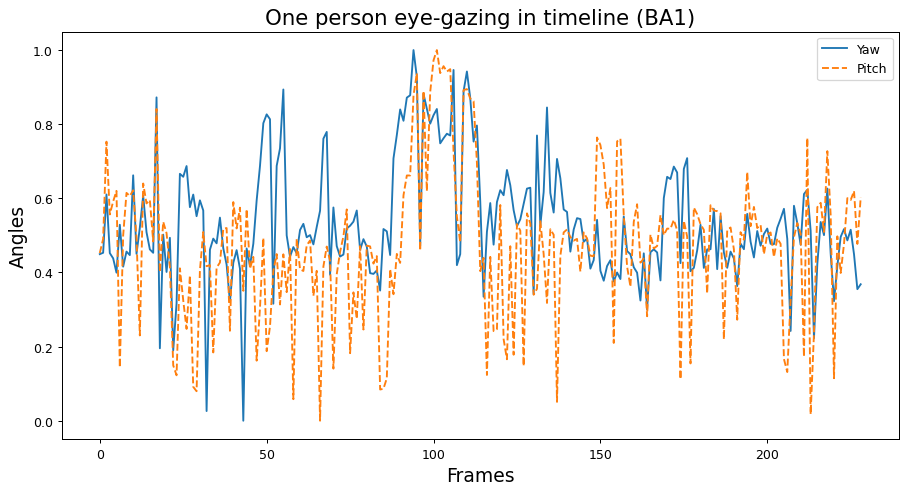

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=90)
# line 1 points
# plotting the line 1 points 
plt.plot(list(range(0, len(df_pichyaw_eyegaze_persion['norm_yaw']))), df_pichyaw_eyegaze_persion['norm_yaw'],label = "Yaw")

# plotting the line 2 points 
plt.plot(list(range(0, len(df_pichyaw_eyegaze_persion['norm_pitch']))), df_pichyaw_eyegaze_persion['norm_pitch'], '--', label = "Pitch")
plt.xlabel('Frames', fontsize=15)

# Set the y axis label of the current axis.
plt.ylabel('Angles', fontsize=15)
# Set a title of the current axes.
plt.title('One person eye-gazing in timeline (BA1)', fontsize=17)
# show a legend on the plot
plt.legend()

# plt.savefig('df_pichyaw_eyegaze_persion_ABA.jpg',bbox_inches='tight')
plt.savefig('df_pichyaw_eyegaze_persion_BA1.jpg',bbox_inches='tight')
# Display a figure.
plt.show()

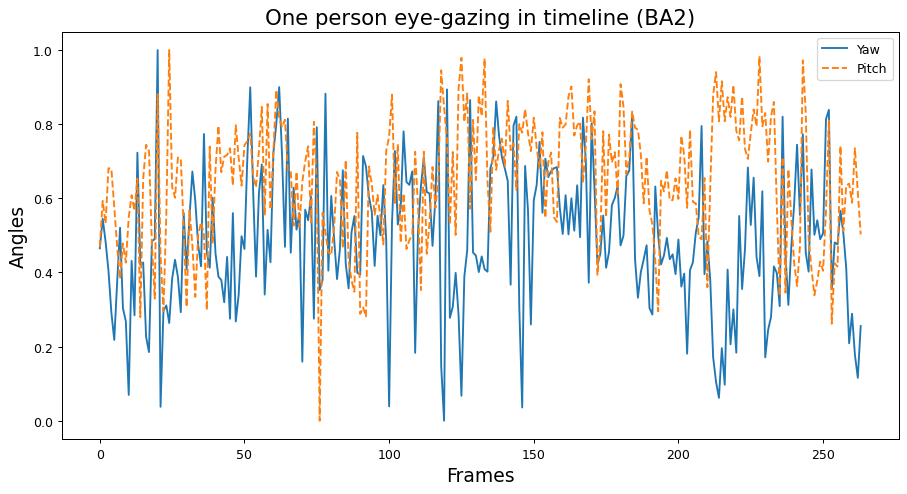

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=90)
# line 1 points
# plotting the line 1 points 
plt.plot(list(range(0, len(df_pichyaw_BA2['norm_yaw']))), df_pichyaw_BA2['norm_yaw'],label = "Yaw")

# plotting the line 2 points 
plt.plot(list(range(0, len(df_pichyaw_BA2['norm_pitch']))), df_pichyaw_BA2['norm_pitch'], '--', label = "Pitch")
plt.xlabel('Frames', fontsize=15)

# Set the y axis label of the current axis.
plt.ylabel('Angles', fontsize=15)
# Set a title of the current axes.
plt.title('One person eye-gazing in timeline (BA2)', fontsize=17)
# show a legend on the plot
plt.legend()

# plt.savefig('df_pichyaw_eyegaze_persion_ABA.jpg',bbox_inches='tight')
plt.savefig('df_pichyaw_eyegaze_persion_BA2.jpg',bbox_inches='tight')
# Display a figure.
plt.show()

In [2]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle
from tqdm import tqdm
import pandas as pd
import pickle
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

#from scipy.misc import imread, imresize

%matplotlib inline

In [44]:
eyegaze_df_part3_A = pd.read_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part3/Part3_A_eyegaze_20308.csv')
eyegaze_df_part3_A.head()

,image_ID,pitch,yaw,condition,pitchyaw
0,frame_face_A_0.jpg,-0.220532,-0.124333,A,0.344866
1,frame_face_A_1.jpg,-0.337533,0.240230,A,0.577763
2,frame_face_A_10.jpg,-0.348503,0.211334,A,0.559837
3,frame_face_A_100.jpg,-0.508876,-0.097049,A,0.605925
4,frame_face_A_1000.jpg,-0.609161,0.121039,A,0.730200


In [54]:
eyegaze_df_part3_B.head()

,image_ID,pitch,yaw,condition,pitchyaw
0,frame_face_B_0.jpg,-0.311332,-0.159489,B,0.470820
1,frame_face_B_1.jpg,-0.463338,-0.193584,B,0.656922
2,frame_face_B_1000.jpg,-0.865600,0.177293,B,1.042892
3,frame_face_B_1001.jpg,-0.805479,0.037955,B,0.843434
4,frame_face_B_1002.jpg,-0.792204,0.150415,B,0.942620


In [55]:
eyegaze_df_part3_B = pd.read_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part3/Part3_B_eyegaze_5465.csv')
eyegaze_df_part3_B.head()

,image_ID,pitch,yaw,condition,pitchyaw
0,frame_face_B_0.jpg,-0.311332,-0.159489,B,0.470820
1,frame_face_B_1.jpg,-0.463338,-0.193584,B,0.656922
2,frame_face_B_1000.jpg,-0.865600,0.177293,B,1.042892
3,frame_face_B_1001.jpg,-0.805479,0.037955,B,0.843434
4,frame_face_B_1002.jpg,-0.792204,0.150415,B,0.942620


In [59]:
eyegaze_df_part3_B.to_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part3/eyegaze_df_part3_B_norm.csv')

In [61]:
len(eyegaze_df_part3_A)

20308

In [58]:
#normalise
min_em= eyegaze_df_part3_B['pitchyaw'].min()
max_em= eyegaze_df_part3_B['pitchyaw'].max()
range_max_min = max_em - min_em
eyegaze_df_part3_B['norm_pitchyaw'] = (eyegaze_df_part3_B['pitchyaw']-min_em) / range_max_min
eyegaze_df_part3_B.head()

,image_ID,pitch,yaw,condition,pitchyaw,norm_pitch,norm_yaw,norm_pitchyaw
0,frame_face_B_0.jpg,-0.311332,-0.159489,B,0.470820,0.624485,0.333283,0.289246
1,frame_face_B_1.jpg,-0.463338,-0.193584,B,0.656922,0.481406,0.314838,0.414881
2,frame_face_B_1000.jpg,-0.865600,0.177293,B,1.042892,0.102769,0.515475,0.675446
3,frame_face_B_1001.jpg,-0.805479,0.037955,B,0.843434,0.159359,0.440096,0.540794
4,frame_face_B_1002.jpg,-0.792204,0.150415,B,0.942620,0.171854,0.500935,0.607753


In [8]:
eyegaze_df_part1_B = pd.read_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part1/part1_B_eyegaze.csv')
eyegaze_df_part1_B.head()

,image_ID,pitch,yaw,condition,pitchyaw
0,frame_B0.jpg,-0.399129,0.159691,B,0.558819
1,frame_B1.jpg,-0.537233,0.182206,B,0.719440
2,frame_B10.jpg,-0.464701,-0.049505,B,0.514205
3,frame_B100.jpg,-0.445426,0.277472,B,0.722899
4,frame_B1000.jpg,-0.529797,-0.006351,B,0.536148


In [39]:
eyegaze_df_part1_B.to_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part1/eyegaze_df_part1_B_norm.csv')

In [22]:
len(df_part1_A_sample1)

4939

In [27]:
eyegaze_df_part2_A2 = pd.read_csv("/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2/part2_eyegaze_combined/part2_A2_eyegaze_norm.csv")
eyegaze_df_part2_A2.head()

,image_ID,pitch,yaw,pitchyaw,norm_pitch,norm_yaw,norm_pitchyaw,condition
0,frame_face_A2_0.jpg,-0.536809,-0.073554,0.610363,0.293034,0.417679,0.387870,A2
1,frame_face_A2_1.jpg,-0.533478,0.040757,0.574236,0.295363,0.477069,0.364631,A2
2,frame_face_A2_10.jpg,-0.655535,0.254213,0.909748,0.210033,0.587969,0.580453,A2
3,frame_face_A2_100.jpg,-0.433677,0.097058,0.530736,0.365134,0.506320,0.336649,A2
4,frame_face_A2_1000.jpg,-0.358248,-0.143405,0.501654,0.417866,0.381388,0.317942,A2


In [32]:
eyegaze_df_part2_A2_sample = eyegaze_df_part2_A2.sample(n=9575)
eyegaze_df_part2_A2_sample.head()

,image_ID,pitch,yaw,pitchyaw,norm_pitch,norm_yaw,norm_pitchyaw,condition
8822,frame_face_A2_20846.jpg,-0.636764,-0.039634,0.676398,0.223155,0.435303,0.430348,A2
8076,frame_face_A2_20069.jpg,-0.774064,-0.536138,1.310202,0.127168,0.177346,0.838049,A2
12175,frame_face_A2_24323.jpg,-0.738016,0.006290,0.744306,0.152370,0.459162,0.474031,A2
12916,frame_face_A2_25001.jpg,-0.361056,0.113400,0.474456,0.415903,0.514811,0.300447,A2
675,frame_face_A2_10745.jpg,0.203882,0.357019,0.560901,0.810853,0.641382,0.356053,A2


In [33]:
eyegaze_df_part2_A2_sample.to_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2/part2_eyegaze_combined/part2_A2_eyegaze_sample3_norm_9575.csv')

In [13]:
def randomize(df):
    return df.sample(frac=1)
df_shuffled = eyegaze_df_part1_A
for x in range(15):
    df_shuffled = randomize(eyegaze_df_part1_A) 

In [14]:
len(df_shuffled)

8586

In [32]:
eyegaze_df_part3_A_5465 = df_shuffled[0:4939]
eyegaze_df_part3_A_5465.head()

,image_ID,pitch,yaw,condition,pitchyaw
7397,frame_face_A_20185.jpg,-0.232831,0.195455,A,0.428285
8434,frame_face_A_21178.jpg,-0.310454,0.358884,A,0.669338
7440,frame_face_A_20227.jpg,-0.346631,-0.052453,A,0.399084
18788,frame_face_A_7528.jpg,-0.587495,-0.219048,A,0.806543
17479,frame_face_A_4648.jpg,-0.373048,0.087218,A,0.460266


In [33]:
eyegaze_df_part3_AB_5465 = pd.concat([eyegaze_df_part3_A_5465, eyegaze_df_part3_B])
len(eyegaze_df_part3_AB_5465)

10930

In [34]:
eyegaze_df_part3_AB_5465.to_csv('/home/nali/Develop/HRI/data/HRI_Study2/eye_gazing/eyegaze_df_part3_AB_5465.csv')

## Normalisation

### Eye-gaze

In [26]:
eyegaze_A1_beforehelp_df = pd.read_csv("/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2_A1_beforehelp_eyegaze_11935.csv")
eyegze_A1_withhelp_df = pd.read_csv("/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2_A1_help_eyegaze_12938.csv")

In [33]:
eyegze_A1_withhelp_df.head()

,image_ID,pitch,yaw,condition,pitchyaw
0,frame_face_A1_help_0.jpg,-0.316071,-0.514203,A1_help,0.830274
1,frame_face_A1_help_1.jpg,-0.233676,-0.325659,A1_help,0.559334
2,frame_face_A1_help_10.jpg,-0.344183,0.821820,A1_help,1.166003
3,frame_face_A1_help_1000.jpg,-0.355562,0.000380,A1_help,0.355942
4,frame_face_A1_help_10000.jpg,-0.551660,0.752907,A1_help,1.304567


In [34]:
eyegze_A1_withhelp_df.head()

,image_ID,pitch,yaw,condition,pitchyaw
0,frame_face_A1_help_0.jpg,-0.316071,-0.514203,A1_help,0.830274
1,frame_face_A1_help_1.jpg,-0.233676,-0.325659,A1_help,0.559334
2,frame_face_A1_help_10.jpg,-0.344183,0.821820,A1_help,1.166003
3,frame_face_A1_help_1000.jpg,-0.355562,0.000380,A1_help,0.355942
4,frame_face_A1_help_10000.jpg,-0.551660,0.752907,A1_help,1.304567


In [37]:
#normalise
min_em= eyegze_A1_withhelp_df['pitchyaw'].min()
max_em= eyegze_A1_withhelp_df['pitchyaw'].max()
range_max_min = max_em - min_em
eyegze_A1_withhelp_df['norm_pitchyaw'] = (eyegze_A1_withhelp_df['pitchyaw']-min_em) / range_max_min
eyegze_A1_withhelp_df.head()

,image_ID,pitch,yaw,condition,pitchyaw,norm_yaw,norm_pitch,norm_pitchyaw
0,frame_face_A1_help_0.jpg,-0.316071,-0.514203,A1_help,0.830274,0.181269,0.440266,0.471074
1,frame_face_A1_help_1.jpg,-0.233676,-0.325659,A1_help,0.559334,0.271760,0.497510,0.316210
2,frame_face_A1_help_10.jpg,-0.344183,0.821820,A1_help,1.166003,0.822491,0.420736,0.662971
3,frame_face_A1_help_1000.jpg,-0.355562,0.000380,A1_help,0.355942,0.428242,0.412831,0.199954
4,frame_face_A1_help_10000.jpg,-0.551660,0.752907,A1_help,1.304567,0.789416,0.276594,0.742172


In [39]:
eyegze_A1_withhelp_df.to_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2_A1_help_eyegaze_12938_norm.csv')
# headpose_B_df.to_csv('/home/nali/Develop/HRI/headpose_B_norm.csv')

### head pose

In [50]:
headpose_A1_beforehelp_df = pd.read_csv("/home/nali/Develop/HRI/data/HRI_Study2_result_csv/head_pose/part2_A1_beforehelp_headpose.csv")
headpose_A1_withhelp_df = pd.read_csv("/home/nali/Develop/HRI/data/HRI_Study2_result_csv/head_pose/part2_A1_help_headpose.csv")

In [51]:
headpose_A1_beforehelp_df.head()

,image_ID,roll,pitch,yaw,condition,rollpitchyaw
0,part2_faceAlign_frame_face_A1_beforehelp_100.jpg,3.650083,8.285615,12.309401,A1_beforehelp,24.245100
1,part2_faceAlign_frame_face_A1_beforehelp_1000.jpg,-4.573395,-18.049318,-0.406562,A1_beforehelp,23.029276
2,part2_faceAlign_frame_face_A1_beforehelp_10000...,9.277394,-7.178245,21.305870,A1_beforehelp,37.761510
3,part2_faceAlign_frame_face_A1_beforehelp_10001...,2.436626,-8.295723,34.186996,A1_beforehelp,44.919346
4,part2_faceAlign_frame_face_A1_beforehelp_10002...,9.425232,-5.786358,3.618629,A1_beforehelp,18.830220


In [58]:
headpose_A1_withhelp_df.head()

,image_ID,roll,pitch,yaw,condition,rollpitchyaw
0,part2_faceAlign_frame_face_A1_help_0.jpg,-4.327936,-6.113792,0.406051,A1_help,10.847779
1,part2_faceAlign_frame_face_A1_help_1.jpg,-4.778994,-4.699060,-3.538148,A1_help,13.016202
2,part2_faceAlign_frame_face_A1_help_10.jpg,5.328642,0.873866,15.581953,A1_help,21.784460
3,part2_faceAlign_frame_face_A1_help_100.jpg,4.319906,7.001792,10.421431,A1_help,21.743128
4,part2_faceAlign_frame_face_A1_help_1000.jpg,7.518011,-5.499589,-10.954856,A1_help,23.972456


In [62]:
#normalise
min_em= headpose_A1_withhelp_df['rollpitchyaw'].min()
max_em= headpose_A1_withhelp_df['rollpitchyaw'].max()
range_max_min = max_em - min_em
headpose_A1_withhelp_df['norm_rollpitchyaw'] = (headpose_A1_withhelp_df['rollpitchyaw']-min_em) / range_max_min
headpose_A1_withhelp_df.head()

,image_ID,roll,pitch,yaw,condition,rollpitchyaw,norm_pitch,norm_yaw,norm_roll,norm_rollpitchyaw
0,part2_faceAlign_frame_face_A1_help_0.jpg,-4.327936,-6.113792,0.406051,A1_help,10.847779,0.422011,0.489154,0.367369,0.109482
1,part2_faceAlign_frame_face_A1_help_1.jpg,-4.778994,-4.699060,-3.538148,A1_help,13.016202,0.454928,0.462004,0.354894,0.132905
2,part2_faceAlign_frame_face_A1_help_10.jpg,5.328642,0.873866,15.581953,A1_help,21.784460,0.584596,0.593618,0.634435,0.227620
3,part2_faceAlign_frame_face_A1_help_100.jpg,4.319906,7.001792,10.421431,A1_help,21.743128,0.727177,0.558095,0.606537,0.227174
4,part2_faceAlign_frame_face_A1_help_1000.jpg,7.518011,-5.499589,-10.954856,A1_help,23.972456,0.436302,0.410951,0.694984,0.251255


In [57]:
headpose_A1_beforehelp_df.to_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/head_pose/part2_A1_beforehelp_headpose_norm.csv')

In [1]:
headpose_A1_withhelp_df.to_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/head_pose/part2_A1_help_headpose_norm.csv')

NameError: name 'headpose_A1_withhelp_df' is not defined

In [2]:
eyegaze_A1_beforehelp_df = pd.read_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2/part2_A1_beforehelp_eyegaze_11935_norm.csv')
eyegaze_A1_beforehelp_df.head()

,image_ID,pitch,yaw,pitchyaw,norm_pitch,norm_yaw,norm_pitchyaw,condition
0,frame_face_A1_beforehelp_100.jpg,-0.325505,0.378338,0.703844,0.441953,0.631531,0.385220,A1_beforehelp
1,frame_face_A1_beforehelp_1000.jpg,-0.555874,-0.051801,0.607675,0.275822,0.420597,0.331516,A1_beforehelp
2,frame_face_A1_beforehelp_10000.jpg,-0.706991,-0.165128,0.872119,0.166844,0.365023,0.479191,A1_beforehelp
3,frame_face_A1_beforehelp_10001.jpg,-0.080368,0.342789,0.423156,0.618735,0.614098,0.228473,A1_beforehelp
4,frame_face_A1_beforehelp_10002.jpg,-0.574099,-0.399363,0.973462,0.262679,0.250158,0.535784,A1_beforehelp


In [3]:
eyegaze_A1_withhelp_df = pd.read_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2/part2_A1_help_eyegaze_12938_norm.csv')
eyegaze_A1_withhelp_df.head()

,image_ID,pitch,yaw,condition,pitchyaw,norm_yaw,norm_pitch,norm_pitchyaw
0,frame_face_A1_help_0.jpg,-0.316071,-0.514203,A1_help,0.830274,0.181269,0.440266,0.471074
1,frame_face_A1_help_1.jpg,-0.233676,-0.325659,A1_help,0.559334,0.271760,0.497510,0.316210
2,frame_face_A1_help_10.jpg,-0.344183,0.821820,A1_help,1.166003,0.822491,0.420736,0.662971
3,frame_face_A1_help_1000.jpg,-0.355562,0.000380,A1_help,0.355942,0.428242,0.412831,0.199954
4,frame_face_A1_help_10000.jpg,-0.551660,0.752907,A1_help,1.304567,0.789416,0.276594,0.742172


In [4]:
eyegaze_A1_B = pd.read_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2/part2_A1_B_eyegaze_4914_norm.csv')
eyegaze_A1_B.head()

,image_ID,pitch,yaw,condition,pitchyaw,norm_pitchyaw,norm_pitch,norm_yaw
0,frame_face_B_A1_0.jpg,-0.408082,0.039719,A1_B,0.447801,0.253170,0.395659,0.427900
1,frame_face_B_A1_1.jpg,-0.420820,0.148450,A1_B,0.569270,0.324486,0.386038,0.490950
2,frame_face_B_A1_10.jpg,-0.422437,-0.254987,A1_B,0.677424,0.387985,0.384817,0.257008
3,frame_face_B_A1_1000.jpg,-0.413581,0.188517,A1_B,0.602098,0.343760,0.391505,0.514184
4,frame_face_B_A1_1001.jpg,-0.372494,0.382549,A1_B,0.755043,0.433556,0.422536,0.626698


In [5]:
eyegaze_A1_withhelp_df['norm_pitchyaw'].head()

0    0.471074
1    0.316210
2    0.662971
3    0.199954
4    0.742172
Name: norm_pitchyaw, dtype: float64

/home/nali/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


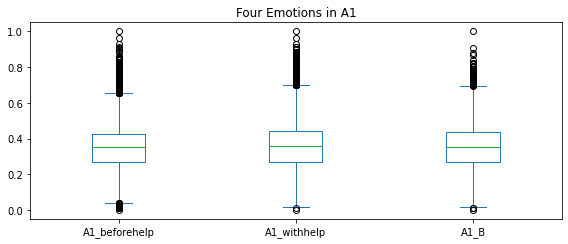

In [63]:
#  group boxplot
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = [8, 3.50]
# plt.rcParams["figure.autolayout"] = True


data = pd.DataFrame({"A1_beforehelp": eyegaze_A1_beforehelp_df['norm_pitchyaw'], 
                     "A1_withhelp": eyegaze_A1_withhelp_df['norm_pitchyaw'], 
                     "A1_B": eyegaze_A1_B['norm_pitchyaw']})

ax = data[['A1_beforehelp', 'A1_withhelp', 'A1_B']].plot(kind='box', title='Four Emotions in A1')

plt.show()

In [1]:
eyegaze_A2_df = pd.read_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2/part2_A2_eyegaze_norm_22077.csv')
eyegaze_A2_df.head()

NameError: name 'pd' is not defined

In [7]:
eyegaze_A2_B_df = pd.read_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2/part2_A2_B_eyegaze_norm_4661.csv')
eyegaze_A2_B_df.head()

,image_ID,pitch,yaw,condition,pitchyaw,norm_yaw,norm_pitch,norm_pitchyaw
0,frame_face_B_A2_0.jpg,-0.299654,0.149741,A2_B,0.449396,0.520130,0.501343,0.319135
1,frame_face_B_A2_1.jpg,-0.452460,0.151569,A2_B,0.604029,0.521176,0.381300,0.431926
2,frame_face_B_A2_10.jpg,-0.340130,0.092225,A2_B,0.432356,0.487190,0.469545,0.306706
3,frame_face_B_A2_100.jpg,-0.299374,0.131135,A2_B,0.430509,0.509474,0.501563,0.305359
4,frame_face_B_A2_1000.jpg,-0.329774,-0.545559,A2_B,0.875333,0.121922,0.477681,0.629816


/home/nali/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


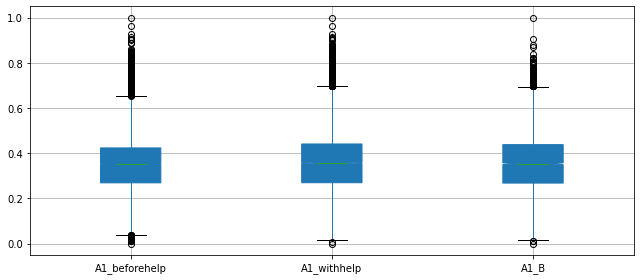

In [71]:
#  group boxplot
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = [9, 4]
# plt.rcParams["figure.autolayout"] = True
colors = ['pink', 'lightblue', 'lightgreen']
labels = ['A1_beforehelp', 'A1_withhelp', 'A1_B']
data = pd.DataFrame({"A1_beforehelp": eyegaze_A1_beforehelp_df['norm_pitchyaw'], 
                     "A1_withhelp": eyegaze_A1_withhelp_df['norm_pitchyaw'], 
                     "A1_B": eyegaze_A1_B['norm_pitchyaw']})

# ax = data[['A1_beforehelp', 'A1_withhelp', 'A1_B']].plot(kind='box', title='Four Emotions in A1')

ax = data[['A1_beforehelp', 'A1_withhelp', 'A1_B']].boxplot(vert=True,  # vertical box alignment
                      notch=True,  
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax.yaxis.grid(True)
plt.show()

/home/nali/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


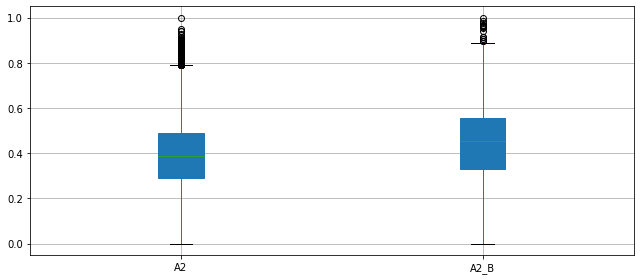

In [68]:
#  group boxplot
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = [9, 4]
plt.rcParams["figure.autolayout"] = True
labels = ['A2', 'A2_B']
data = pd.DataFrame({"A2": eyegaze_A2_df['norm_pitchyaw'],"A2_B": eyegaze_A2_B_df['norm_pitchyaw']})

# ax = data[['A1_beforehelp', 'A1_withhelp', 'A1_B']].plot(kind='box', title='Four Emotions in A1')

ax = data[['A2', 'A2_B']].boxplot(vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color,
                     labels=labels)  # will be used to label x-ticks
ax.yaxis.grid(True)
plt.show()

In [48]:
eyegaze_A1_B.head()

,image_ID,pitch,yaw,condition,pitchyaw,norm_pitchyaw,norm_pitch,norm_yaw
0,frame_face_B_A1_0.jpg,-0.408082,0.039719,A1_B,0.447801,0.253170,0.395659,0.427900
1,frame_face_B_A1_1.jpg,-0.420820,0.148450,A1_B,0.569270,0.324486,0.386038,0.490950
2,frame_face_B_A1_10.jpg,-0.422437,-0.254987,A1_B,0.677424,0.387985,0.384817,0.257008
3,frame_face_B_A1_1000.jpg,-0.413581,0.188517,A1_B,0.602098,0.343760,0.391505,0.514184
4,frame_face_B_A1_1001.jpg,-0.372494,0.382549,A1_B,0.755043,0.433556,0.422536,0.626698


In [50]:
eyegaze_A2_B_df.head()

,image_ID,pitch,yaw,condition,pitchyaw,norm_yaw,norm_pitch,norm_pitchyaw
0,frame_face_B_A2_0.jpg,-0.299654,0.149741,A2_B,0.449396,0.520130,0.501343,0.319135
1,frame_face_B_A2_1.jpg,-0.452460,0.151569,A2_B,0.604029,0.521176,0.381300,0.431926
2,frame_face_B_A2_10.jpg,-0.340130,0.092225,A2_B,0.432356,0.487190,0.469545,0.306706
3,frame_face_B_A2_100.jpg,-0.299374,0.131135,A2_B,0.430509,0.509474,0.501563,0.305359
4,frame_face_B_A2_1000.jpg,-0.329774,-0.545559,A2_B,0.875333,0.121922,0.477681,0.629816


In [51]:
result = [eyegaze_A1_B, eyegaze_A2_B_df]
condition_B = pd.concat(result)
condition_B.reset_index(drop=True)

,image_ID,pitch,yaw,condition,pitchyaw,norm_pitchyaw,norm_pitch,norm_yaw
0,frame_face_B_A1_0.jpg,-0.408082,0.039719,A1_B,0.447801,0.253170,0.395659,0.427900
1,frame_face_B_A1_1.jpg,-0.420820,0.148450,A1_B,0.569270,0.324486,0.386038,0.490950
2,frame_face_B_A1_10.jpg,-0.422437,-0.254987,A1_B,0.677424,0.387985,0.384817,0.257008
3,frame_face_B_A1_1000.jpg,-0.413581,0.188517,A1_B,0.602098,0.343760,0.391505,0.514184
4,frame_face_B_A1_1001.jpg,-0.372494,0.382549,A1_B,0.755043,0.433556,0.422536,0.626698
...,...,...,...,...,...,...,...,...
9570,frame_face_B_A2_995.jpg,-0.493307,0.072776,A2_B,0.566083,0.404248,0.349212,0.476051
9571,frame_face_B_A2_996.jpg,-0.474052,0.021086,A2_B,0.495138,0.352500,0.364339,0.446447
9572,frame_face_B_A2_997.jpg,-0.898299,0.108334,A2_B,1.006633,0.725587,0.031057,0.496415
9573,frame_face_B_A2_998.jpg,-0.550250,0.047990,A2_B,0.598240,0.427703,0.304478,0.461855


In [54]:
condition_B.to_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/conditionB.csv')

In [55]:
condition_B = pd.read_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/conditionB.csv')

In [56]:
condition_B.head()

,image_ID,pitch,yaw,condition,pitchyaw,norm_pitchyaw,norm_pitch,norm_yaw
0,frame_face_B_A1_0.jpg,-0.408082,0.039719,A1_B,0.447801,0.253170,0.395659,0.427900
1,frame_face_B_A1_1.jpg,-0.420820,0.148450,A1_B,0.569270,0.324486,0.386038,0.490950
2,frame_face_B_A1_10.jpg,-0.422437,-0.254987,A1_B,0.677424,0.387985,0.384817,0.257008
3,frame_face_B_A1_1000.jpg,-0.413581,0.188517,A1_B,0.602098,0.343760,0.391505,0.514184
4,frame_face_B_A1_1001.jpg,-0.372494,0.382549,A1_B,0.755043,0.433556,0.422536,0.626698


In [2]:
#  group boxplot
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [3]:
eyegaze_A1_beforehelp_df = pd.read_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2/part2_A1_beforehelp_eyegaze_11935_norm.csv')
eyegaze_A1_withhelp_df = pd.read_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2/part2_A1_help_eyegaze_12938_norm.csv')
eyegaze_B_A1_df =  pd.read_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2/part2_A1_B_eyegaze_4914_norm.csv')
eyegaze_A2_df = pd.read_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2/part2_A2_eyegaze_norm_22077.csv')
eyegaze_B_A2_df = pd.read_csv('/home/nali/Develop/HRI/data/HRI_Study2_result_csv/eye_gazing/part2/part2_A2_B_eyegaze_norm_4661.csv')

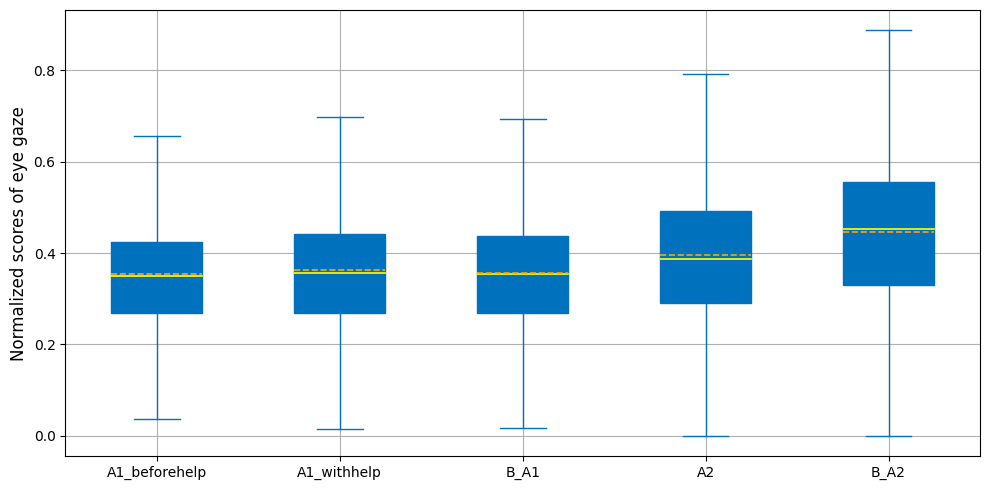

In [5]:

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
labels = ['A1_beforehelp', 'A1_withhelp', 'B_A1', 'A2', 'B_A2']
medianprops = dict(linestyle='-', linewidth=1.2, color='yellow')
meanpointprops = dict(linestyle='--', linewidth=1.2, color='orange')

data = pd.DataFrame({
    "A1_beforehelp": eyegaze_A1_beforehelp_df['norm_pitchyaw'], 
    "A1_withhelp": eyegaze_A1_withhelp_df['norm_pitchyaw'], 
    "B_A1": eyegaze_B_A1_df['norm_pitchyaw'],
    "A2": eyegaze_A2_df['norm_pitchyaw'],
    "B_A2": eyegaze_B_A2_df['norm_pitchyaw']
})

# ax = data[['A1_beforehelp', 'A1_withhelp', 'A1_B']].plot(kind='box', title='Four Emotions in A1')

ax = data[['A1_beforehelp','A1_withhelp', 'B_A1', 'A2', 'B_A2']].boxplot(vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color,
                     medianprops=medianprops,
                     meanprops=meanpointprops,
                     labels=labels,
                     showfliers=False,
                     showmeans=True,
                     meanline = True,
                                                                
                     color= "#0072BD"
        )  # will be used to label x-ticks

ax.yaxis.grid(True)
# ax.set_ylabel('Normalised scores of eye gaze', fontsize= 12)
ax.set_ylabel('Normalized scores of eye gaze', fontsize= 12)
#plt.title('Eye Gaze Estimation', fontsize=14)
plt.savefig('Eye_gaze_estimation_full.jpg')
plt.show()